# IsicApi syntax (as well as tests and examples you can run)
This notebook is meant to provide an overview of the syntax, and also
function as both a bit of a test suite and to help you familiarize
yourself with the ```IsicApi``` class, giving some useful examples of
code that you might find useful when writing your own programs.

Each cell contains all the code necessary to run, so **you can execute
them separately**. In addition, above each cell of code, some
explanation is provided as to what the example (cell) is about.

## Selecting from all publicly available images
The following example demonstrates how to select images from the
archive. This **also** works when you're logged in, only that then a
lot more images might be available. Also, if you set the cache_folder
parameter during the call to ```IsicApi```, the results will be
stored for later use, which means you only have to download the list
of images once.

### Syntax
The call itself is done using the ```IsicApi.select_images``` method.
There is only one mandatory parameter, which is the list of search
criteria you want to apply to the (full) list of available images.
The syntax for each selection criterion is a list of 3 elements:

- **field name** (where . separates the levels in the hierarchy)
- **operator** (one of '==', '!=', '<', '<=', '>', '>=', 'in', 'not in', 'ni', 'not ni', 'match', 'not match', 'is', 'not is', 'is None', 'not is None'
- **comparison value** to which the contents of the field will be compared to

The 'ni' (and 'not ni') operator reverse the direction of 'in' (and
'not in'). So **'ni' (or 'not ni') tests whether the *comparison value*
appears in the field, whereas 'in' and 'not in' test whether the field
appears in the *comparison value***.

Other keyword parameters include:
- **sub_select** which can either be a dict containing a selection of images ```{image_id: image_JSON, ...}```, or a bool value, whereas True means that the previous selection is used as the basis, so ```sub_select=True``` means that a further restriction is applied
- **add_to_selection** as bool value, with the default of False; if set to True, whatever images are found by the current select operation will be added to the already selected images, this can be useful when creating a list of images that are the Union of a complex set of criteria
- **remove_from_selection** as bool value, with the default of False; if set to True works the opposite way, such that any item that matches the selection will be removed from the already made selection (negative selection)

The selected images will be returned as a dictionary ```{image_id: image_JSON, ...}```, and the last selection is also stored in ```api.image_selection```.

### func.getxattr
Also used in this example is the function ```getxattr``` from the
```isicarchive.func``` module. It allows to extract a value from a
complex JSON-based dictionary without the necessity to check each
layer (dict) for whether a key exists in a simple syntax: **it
combines object and dict access** with ```struct.field```.

In [1]:
# Imports, etc.
from isicarchive import IsicApi, func
api = IsicApi()

# Start with full collection
api.select_images([])
print('{0:d} images available.'.format(len(api.image_cache)))

# Select all images with string 'melano' in diagnosis classification
# Please 
api.select_images(['meta.clinical.diagnosis', 'ni', 'melano'])
print('{0:d} images containing ''melano'' in diagnosis.'.format(len(api.image_selection)))

# Sub select images of people known to be at most 40 years old
api.select_images(['meta.clinical.age_approx', '<=', 40], sub_select=True)
print('Of those {0:d} images from patients age <= 40.'.format(len(api.image_selection)))

# Remove from those cases where both X and Y dimensions are <= 1024
# and remove images that where either X or Y dimensions are > 4096
too_small = 1024
too_large = 4096
api.select_images([
    ['meta.acquisition.pixelsX', '<=', too_small],
    ['meta.acquisition.pixelsY', '<=', too_small]],
    sub_select=True, remove_from_selection=True)
api.select_images(['meta.acquisition.pixelsX', '>', too_large],
    sub_select=True, remove_from_selection=True)
api.select_images(['meta.acquisition.pixelsY', '>', too_large],
    sub_select=True, remove_from_selection=True)
print('Of those {0:d} images are medium-resolution.'.format(len(api.image_selection)))

# Create a dictionary with anatomical sites
anatomical_sites = list(set([
    func.getxattr(image, 'meta.clinical.anatom_site_general')
    for image in api.image_selection.values()]))
images_by_site = dict()
for site in anatomical_sites:
    images_by_site[site] = dict()
if None in images_by_site:
    del images_by_site[None]
for image in api.image_selection.values():
    site = func.getxattr(image, 'meta.clinical.anatom_site_general')
    if site:
        images_by_site[site][image['name']] = image
for (site, images) in images_by_site.items():
    print('{0:d} images found at site "{1:s}":'.format(len(images), site))
    for (image_name, image) in images.items():
        print('  {0:s} - with resolution {1:d}-by-{2:d}'.format(
            image_name, image['meta']['acquisition']['pixelsX'],
            image['meta']['acquisition']['pixelsY']))

23906 images available.
2182 images containing melano in diagnosis.
Of those 276 images from patients age <= 40.
Of those 18 images are medium-resolution.
1 images found at site "head/neck":
  ISIC_0001152 - with resolution 1936-by-1296
2 images found at site "upper extremity":
  ISIC_0001154 - with resolution 3872-by-2592
  ISIC_0013936 - with resolution 3008-by-2000
1 images found at site "anterior torso":
  ISIC_0001105 - with resolution 3072-by-2304
1 images found at site "lateral torso":
  ISIC_0001128 - with resolution 3072-by-2304
5 images found at site "lower extremity":
  ISIC_0000026 - with resolution 1504-by-1129
  ISIC_0000035 - with resolution 1504-by-1129
  ISIC_0000043 - with resolution 1504-by-1129
  ISIC_0000054 - with resolution 1504-by-1129
  ISIC_0000176 - with resolution 944-by-1127


## Loading an image, and displaying it
This short example loads one of the images (from the previous cell,
identified by its name), and displays it in the notebook.

### Syntax
To retrieve an image, use the ```IsicApi.image(...)``` call, which
accepts either an image (JSON) dict (e.g. from the selection), or
an image name (e.g. ```'ISIC_0001105'```) or an image id--for more of
an explanation what an image id is, please checkout the
[read-me](https://github.com/neuroelf/isicarchive/blob/master/README.md) 
documentation.

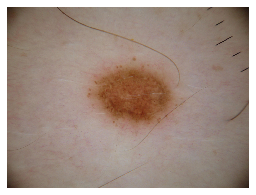

isicarchive.image.Image({
    'id': '54e755f5bae47850e86cdfe0',
    'name': 'ISIC_0001105',
    'dataset_id': '5a2ecc5e1165975c945942a4',
    'dataset_name': 'UDA-2',
    'dataset_description': 'Moles and melanomas.
Biopsy-confirmed melanocytic lesions. Both malignant and benign lesions are included.',
    'dataset_license': 'CC-0',
    'meta_acquisition': '{'image_type': 'dermoscopic', 'pixelsX': 3072, 'pixelsY': 2304}',
    'meta_clinical': '{'age_approx', 'anatom_site_general', 'benign_malignant', 'diagnosis', 'diagnosis_confirm_type', 'melanocytic', 'sex'}',
    'meta_clinical_benign_malignant': 'malignant',
    'meta_clinical_diagnosis': 'melanoma',
    'meta_clinical_diagnosis_confirm_type': 'histopathology',
    'meta_clinical_melanocytic': True,
    'notes_reviewed': '{'accepted': True, 'time': '2015-02-20T15:48:02.394000+00:00', 'userId': '5450e996bae47865794e4d0d'}',
    'superpixels_max': 0,
    'superpixels_shape': (0, 0),})

In [2]:
# Imports, etc.
%matplotlib inline
from isicarchive import IsicApi
api = IsicApi()

# Download image information, then show the image
image = api.image('ISIC_0001105')
image.show_in_notebook(max_size=320)

# And display some information as well
image

## Displaying annotation information
Annotations are responses by ISIC users (typically experts), either as
answers to specific questions (e.g. "Is this lesion benign or malignant?")
or as a per-feature selection of superpixels (please read the
[README.md for an explanation](https://github.com/neuroelf/isicarchive/blob/master/README.md#image-superpixels)).